# EPFL BIO 322 Project  
### Experimental Condition Prediction based on Mouse brain single cell gene expression profiles

### Authors:

- Simon Lee (simon.lee@epfl.ch) 
- Léa Goffinet (lea.goffinet@epfl.ch)

### TOC

* [Data Preprocessing and visualisation](#first-bullet)
* [Method 1: Multinomal Logistic Regression](#second-bullet)
* [Method 2: Multiple Linear Regression with L1 Regularization](#third-bullet)
* [Method 3: XGBoost](#fourth-bullet)

## Project Description

In an experiment on epigenetics and memory, Giulia Santoni (from the lab of Johannes Gräff at
EPFL) measured the gene expression levels in multiple cells of a mouse brain under three different
conditions that we call KAT5, CBP and eGFP. In this challenge, the goal is to predict – as accurately
as possible – for each cell the experimental condition (KAT5, CBP or eGFP) under which it was
measured, given only the gene expression levels.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

from tqdm import tqdm
import requests
import os
import sys
from pathlib import Path
import multiprocessing as mp
from multiprocessing import Process
import concurrent
from multiprocessing import Pool
import xgboost as xgb
import glob

InteractiveShell.ast_node_interactivity = "all"

# Data Preprocessing and visualisation <a class="anchor" id="first-bullet"></a>

This section covers the loading, filtering and visualisation of the data.

In [2]:
# read raw data
df = pd.read_csv('../data/train.csv.gz', compression='gzip')
df

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,labels
0,2.190380,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.293686,CBP
1,2.861984,0.0,0.506726,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506726,KAT5
2,2.766762,0.0,0.629614,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.683511,eGFP
3,2.146434,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.432486,CBP
4,2.840049,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.108581,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.312030,KAT5
4996,3.108972,0.0,0.783343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.518711,eGFP
4997,2.025946,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.025946,CBP
4998,1.227544,0.0,0.791370,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,KAT5


As expected single cell data is extremely sparse. Lets count to see how many non zero entries we actually have per column to get a glimpse of what might be important genes and what might not be important.

In [3]:
gene_column_headers = df.columns.values.tolist()

run this cell only if you want to do filter and write out the counts of how many non zero columns are in each column to a txt file

In [4]:
# # this gets the counts of each column and drops the column accordingly
# f = open('../data/counts.txt', 'w')
# for gene in gene_column_headers:
#     count = (df[gene] != 0).sum()
    
#     f.write('Counts of gene in cells {} : {} \n'.format(gene, count))  # Uncomment if you want to generate text file with counts

#     # new data generator: Takes 3 hrs to run!!
#     # if count < 500:
#     #     df = df.drop(columns=[gene])

# # df.to_csv('../data/filtered_train.csv.gz, compression='gzip')

# f.close()

In [5]:
df_filtered = pd.read_csv('../data/filtered_train.csv.gz')

We can see that the filtering process removed over 22,000 genes that were seen across less than 10% of the cells. Though the threshold is a hyperparameter we believe choosing a smaller hyperparameter will be a safer bet to not throw away useful information

In [6]:
df_filtered

,Unnamed: 0,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,...,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1,labels
0,0,2.190380,0.000000,0.0,0.000000,1.293686,0.000000,1.839343,1.839343,2.190380,...,2.190380,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.293686,CBP
1,1,2.861984,0.506726,0.0,0.000000,0.506726,1.458439,1.291817,1.091771,0.841436,...,0.000000,0.00000,0.000000,0.000000,0.506726,0.000000,0.0,0.000000,0.506726,KAT5
2,2,2.766762,0.629614,0.0,0.000000,1.012971,0.629614,0.629614,0.000000,1.012971,...,0.000000,0.00000,0.000000,0.000000,0.629614,0.000000,0.0,0.000000,1.683511,eGFP
3,3,2.146434,0.000000,0.0,0.000000,0.000000,0.000000,1.060763,0.000000,1.060763,...,0.664895,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.432486,CBP
4,4,2.840049,0.000000,0.0,0.000000,0.000000,1.132100,0.531053,0.000000,1.649491,...,0.531053,0.00000,0.000000,0.000000,0.000000,0.531053,0.0,0.000000,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,2.108581,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.644255,0.644255,...,1.312030,0.00000,0.000000,0.000000,1.032877,0.000000,0.0,0.000000,1.312030,KAT5
4996,4996,3.108972,0.783343,0.0,0.000000,0.000000,0.783343,0.783343,0.466491,1.379256,...,0.466491,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.466491,1.518711,eGFP
4997,4997,2.025946,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.386459,0.000000,...,2.650884,0.00000,2.386459,1.456669,1.456669,0.000000,0.0,1.456669,2.025946,CBP
4998,4998,1.227544,0.791370,0.0,0.000000,0.791370,0.000000,0.791370,0.791370,0.791370,...,2.245478,0.79137,1.227544,0.000000,2.108819,0.000000,0.0,0.000000,0.000000,KAT5


In [7]:
df_filtered = df_filtered.drop(columns='Unnamed: 0')

In [8]:
#check for any null values incase we need to perform imputation
check_nan = df.isnull().values.any()
print(check_nan)

False


In [9]:
gene_column_headers = df_filtered.columns.values.tolist()

We're performing PCA, once with the whole data and once with the filtered data, to see if there is different clusters but also to make sure that the filtered data is corresponding to the raw data.

In [10]:
from sklearn.preprocessing import StandardScaler

x = df.iloc[:, :-1].values
y = df.loc[:,['labels']].values

x = StandardScaler().fit_transform(x)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [12]:
pca.explained_variance_ratio_

array([0.00808732, 0.00516874])

In [13]:
df_pca_final = pd.concat([df_pca, df[['labels']]], axis = 1)

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'PCA : 2 components')

<Figure size 640x480 with 0 Axes>

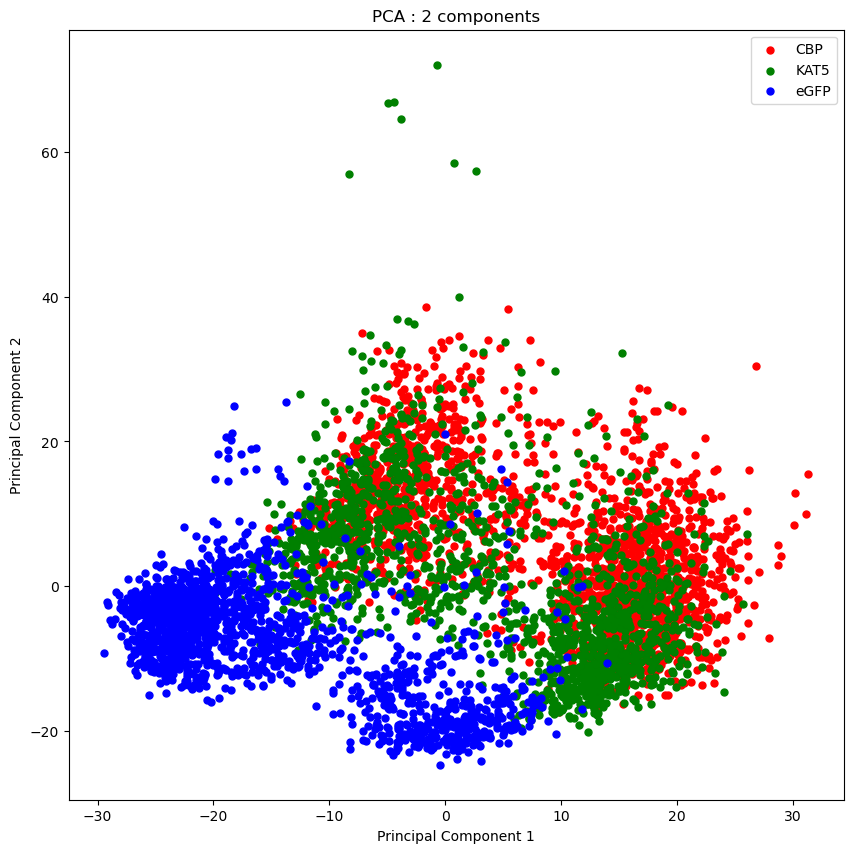

In [14]:
plt.figure()
plt.figure(figsize=(10,10))

labels = ['CBP', 'KAT5', 'eGFP']
colors = ['r', 'g', 'b']
for label, color in zip(labels,colors):
    indicesToKeep = df_pca_final['labels'] == label
    plt.scatter(df_pca_final.loc[indicesToKeep, 'principal component 1'], df_pca_final.loc[indicesToKeep, 'principal component 2'], c = color, s = 25)
plt.legend(labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA : 2 components')
plt.show()

In [15]:
pca.explained_variance_ratio_

array([0.00808732, 0.00516874])

we see very low explained variance with 2 components...

#### same with df_filtered

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, 'PCA : 2 components')

<Figure size 640x480 with 0 Axes>

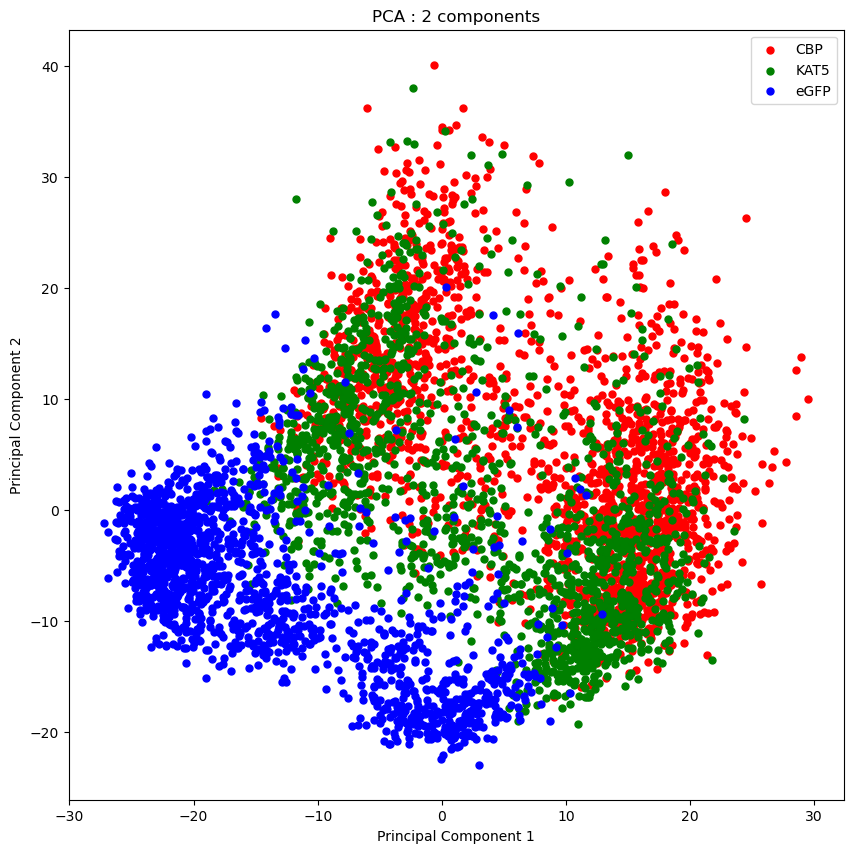

In [17]:
x = df_filtered.iloc[:, :-1].values
y = df_filtered.loc[:,['labels']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

df_pca_final = pd.concat([df_pca, df[['labels']]], axis = 1)

plt.figure()
plt.figure(figsize=(10,10))

labels = ['CBP', 'KAT5', 'eGFP']
colors = ['r', 'g', 'b']
for label, color in zip(labels,colors):
    indicesToKeep = df_pca_final['labels'] == label
    plt.scatter(df_pca_final.loc[indicesToKeep, 'principal component 1'], df_pca_final.loc[indicesToKeep, 'principal component 2'], c = color, s = 25)
plt.legend(labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA : 2 components')
plt.show()

# Method 1 : Multinomial Logistic Regression <a class="anchor" id="second-bullet"></a>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [19]:
X = df_filtered.iloc[:,:-1].values
y = df_filtered['labels'].values

X = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [20]:
X_train.shape, y_test.shape

((4000, 9137), (1000,))

In [21]:

classifier = LogisticRegression(multi_class='multinomial',solver ='saga')
classifier.fit(X_train, y_train) 

/Users/simonlee/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='saga')

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
cm = confusion_matrix(y_test, y_pred)


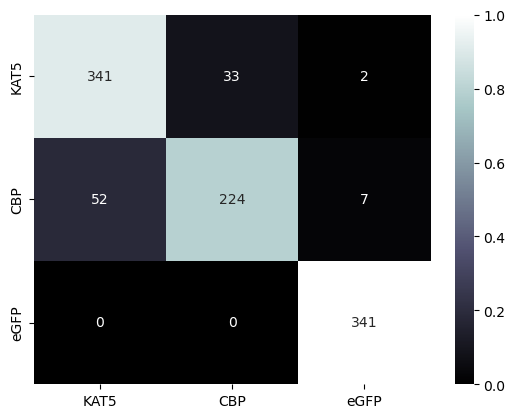

In [24]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, ['KAT5', 'CBP', 'eGFP'])

In [25]:
classifier.score(X_test, y_test)

0.906

# Method 2 : Multiple linear regression with L1 regularization <a class="anchor" id="third-bullet"></a>

In [26]:
#mmmmm Logistic is so good, I'm not sure it's worth it to let multiple linear regression, ?

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

In [28]:
X = df_filtered.iloc[:,:-1]
y = df_filtered['labels']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
  
# Splitting the data into training and testing data
model = LinearRegression()
  
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

LinearRegression()

0.75506369471177


In [30]:
y_pred = model.predict(X_test)

In [31]:
#y_test

In [32]:
#cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm, ['KAT5', 'CBP', 'eGFP'])

In [33]:
X_train

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
1991,3.258097,0.000000,0.000000,0.000000,0.000000,0.870828,1.642228,1.497885,0.870828,0.000000,...,1.880313,2.072473,0.527355,0.870828,0.0,0.870828,0.000000,0.0,0.527355,1.642228
3212,0.863704,0.000000,0.863704,0.000000,0.863704,1.320117,0.000000,1.320117,1.632332,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.863704,0.000000,0.0,0.000000,1.320117
2080,2.435264,0.000000,0.941110,0.000000,0.000000,0.000000,0.713873,0.419330,1.126152,0.000000,...,0.419330,0.941110,0.419330,0.713873,0.0,0.000000,0.000000,0.0,0.419330,0.419330
2241,2.606442,0.000000,0.000000,0.552896,0.000000,1.374505,0.906870,1.374505,0.906870,0.552896,...,0.000000,0.906870,0.552896,0.552896,0.0,0.552896,0.000000,0.0,0.000000,0.000000
4422,2.530041,1.358024,0.000000,0.893739,0.543560,3.088387,1.673868,0.893739,1.528364,0.543560,...,0.893739,0.543560,0.000000,0.543560,0.0,0.000000,0.000000,0.0,0.543560,1.800865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,1.227424,0.000000,0.393720,0.000000,0.000000,2.739198,1.841715,0.393720,1.675670,0.393720,...,0.393720,0.675478,0.000000,0.393720,0.0,0.000000,0.675478,0.0,0.000000,0.393720
341,1.903925,0.000000,0.342180,0.000000,0.000000,1.841212,1.111880,1.237818,1.450233,0.799325,...,0.000000,0.000000,0.342180,0.000000,0.0,0.000000,0.596651,0.0,0.596651,1.625338
1590,2.216416,0.000000,0.000000,0.000000,0.000000,0.859677,1.315012,1.864017,0.000000,0.000000,...,1.864017,2.584871,0.000000,2.055660,0.0,1.864017,0.000000,0.0,0.000000,1.626726
3178,2.566680,0.000000,0.000000,0.000000,0.435980,0.000000,1.158739,1.158739,1.681167,0.000000,...,0.738577,0.738577,0.000000,0.000000,0.0,0.738577,0.738577,0.0,0.970564,2.022572


In [34]:
coeffs = pd.DataFrame()
coeffs['gene'] = X_train.columns
coeffs['coeffcient'] = pd.Series(model.coef_)
coeffs.tail()

,gene,coeffcient
9132,mt-Cytb,0.005231
9133,CAAA01118383.1,-0.000678
9134,Vamp7,-0.000957
9135,Tmlhe,0.004126
9136,AC149090.1,0.034355


In [35]:
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

0.1680730882620358


In [36]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train, y_train)
y_pred1 = lasso.predict(X_test)

Lasso(alpha=1)

In [37]:
mean_squared_error = np.mean((y_pred1 - y_test)**2)
print("Mean squared error on test set", mean_squared_error)

Mean squared error on test set 0.6861925624999999


In [38]:
lasso_coeff = pd.DataFrame()
lasso_coeff['gene_column_headers'] = X_train.columns
lasso_coeff['coefficient'] = pd.Series(lasso.coef_)
 
lasso_coeff.head()

,gene_column_headers,coefficient
0,Xkr4,0.0
1,Gm19938,0.0
2,Mrpl15,0.0
3,Lypla1,0.0
4,Tcea1,0.0


## Method: 3 XGBoost <a class="anchor" id="fourth-bullet"></a>

- Once with our filtered data

In [39]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [40]:
# split into train and validation set using sklearn
gene_column_headers_filtered = gene_column_headers[:-1]
y = df_filtered['labels']
X = df_filtered.iloc[:,:-1]

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [41]:
# perform a typical split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)

training_data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [42]:
X_train.shape

(4000, 9137)

In [43]:
y_train.shape

(4000,)

In [44]:
# fit function where it takes the sklearn and xgboost models and performs the boosted trees.
# plots performance and accuracy as well

def fit(model, training_data=training_data, epochs=300, label_gene = gene_column_headers_filtered):
    # fitting to the sklearn model
    print('Fitting model...')
    model.fit(training_data['X_train'], training_data['y_train'])
    print('Fitting done!')

    # fitting the xboost library model
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    evaluation = {}
    evallist = [(test, 'test'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=evaluation,verbose_eval=100)

    # Model reports
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score: '+str(f1_score(model.predict(training_data['X_test']),training_data['y_test'], average='micro')))
    
    # plotting the error curves for our loss functions
    for m in metrics:
        test_score = evaluation['test'][m]
        train_score = evaluation['train'][m]
        x = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(x, test_score, label="Test")
        plt.plot(x, train_score, label="Train")
        
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Epoch')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
    
    # makes sure that the two array match so we can plot the feature importance
    print("length of features list: {}".format(len(gene_column_headers_filtered)))
    print("length of feature importance vector {}".format(len(model.feature_importances_)))

    return xgb_model

In [45]:
training_data['X_test']

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
4026,3.202564,1.474943,0.000000,0.0,1.474943,0.000000,0.753111,0.000000,1.177790,0.753111,...,2.046605,1.703726,0.753111,1.177790,0.000000,1.474943,0.0,0.000000,0.000000,2.301461
3862,1.897364,0.757838,0.000000,0.0,0.757838,1.481826,0.757838,0.757838,0.757838,0.000000,...,1.711025,1.897364,1.711025,0.000000,0.000000,1.897364,0.0,0.000000,0.000000,0.000000
4711,1.567287,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.150279,3.316198,0.000000,0.000000,0.000000,1.567287,0.0,0.000000,0.000000,0.000000
1724,2.885495,0.424296,0.000000,0.0,0.424296,0.424296,0.721262,0.949934,0.424296,0.000000,...,0.000000,0.424296,0.000000,0.721262,0.000000,0.000000,0.0,0.000000,0.000000,2.401684
4446,2.990145,0.690210,0.000000,0.0,0.690210,0.000000,1.604735,1.604735,1.604735,0.000000,...,0.690210,0.000000,1.094694,1.381886,0.000000,0.000000,0.0,0.000000,0.000000,2.074296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2.873549,0.000000,0.714778,0.0,1.127350,0.714778,1.127350,1.418567,0.000000,0.000000,...,1.127350,1.127350,0.000000,0.714778,0.000000,1.418567,0.0,1.127350,0.000000,2.235361
2386,2.177480,0.625585,0.000000,0.0,0.360934,1.007475,0.360934,1.591686,1.958032,0.000000,...,0.360934,0.834650,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.007475
2820,3.389876,0.851664,0.000000,0.0,0.370078,1.175339,0.639586,1.026541,0.851664,0.000000,...,0.000000,0.639586,0.370078,0.370078,0.000000,0.851664,0.0,0.000000,0.370078,1.026541
478,3.378199,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.060516,0.000000,1.060516,...,0.000000,1.563545,0.000000,0.000000,1.060516,2.146100,0.0,0.000000,1.060516,1.060516


Fitting model...
Fitting done!


/Users/simonlee/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-mlogloss:1.01208	test-merror:0.22200	train-mlogloss:0.98058	train-merror:0.04375
[100]	test-mlogloss:0.34287	test-merror:0.14200	train-mlogloss:0.00646	train-merror:0.00000
[200]	test-mlogloss:0.32817	test-merror:0.13600	train-mlogloss:0.00229	train-merror:0.00000
[299]	test-mlogloss:0.32205	test-merror:0.13300	train-mlogloss:0.00145	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.867
XGBoost F1-Score: 0.867


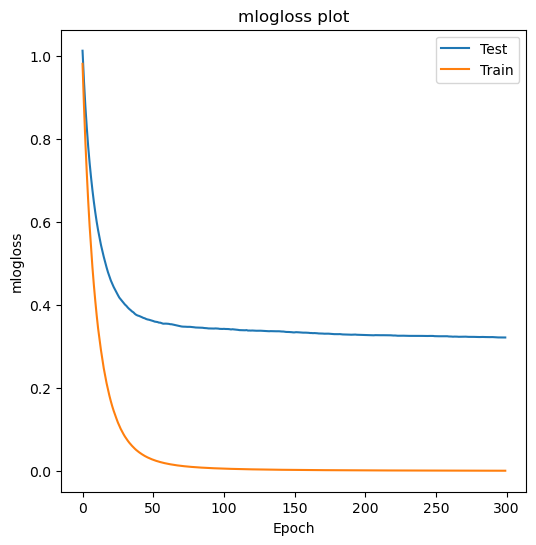

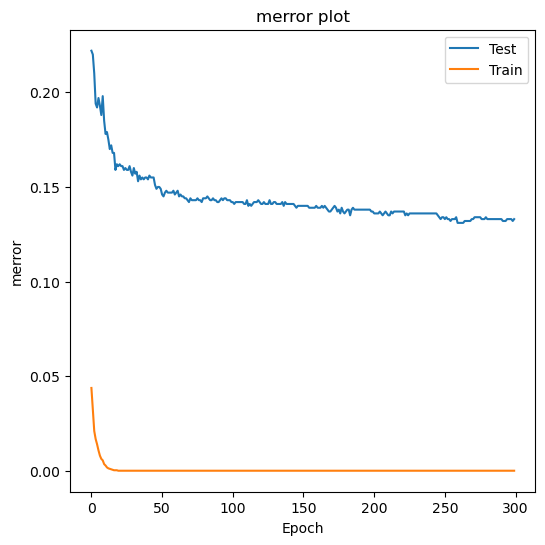

length of features list: 9137
length of feature importance vector 9137


In [46]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

read in test.csv.gz to assess model and predictions

In [47]:
test = pd.read_csv('../data/test.csv.gz', compression='gzip', usecols=gene_column_headers_filtered)
test

,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,Gm26901,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1
0,3.160117,0.683829,0.0,0.000000,0.000000,0.000000,0.000000,1.086169,0.000000,0.000000,...,0.683829,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.683829,1.086169
1,2.145334,0.000000,0.0,0.000000,0.919876,0.000000,0.562178,1.390774,1.562859,0.562178,...,1.562859,2.307958,0.000000,2.145334,0.562178,0.562178,0.0,0.000000,0.000000,2.570459
2,1.871887,0.000000,0.0,0.000000,0.000000,1.540524,1.041519,1.041519,0.000000,0.000000,...,1.041519,2.120352,0.000000,1.540524,1.041519,2.120352,0.0,0.000000,0.000000,2.319205
3,2.090093,0.882582,0.0,0.535655,0.000000,0.000000,1.139658,0.882582,0.535655,0.000000,...,1.343978,1.343978,0.535655,0.882582,0.000000,0.882582,0.0,0.000000,0.535655,1.513551
4,2.180879,0.000000,0.0,0.000000,0.627369,0.627369,0.627369,1.502010,1.009910,0.000000,...,0.000000,1.009910,0.000000,0.000000,0.627369,0.000000,0.0,0.000000,0.627369,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,0.000000,0.000000,0.0,0.000000,0.000000,1.839566,0.000000,0.000000,0.000000,0.000000,...,2.826214,3.098976,1.839566,2.449937,1.839566,1.839566,0.0,0.000000,1.839566,3.884534
3089,2.622857,0.000000,0.0,0.000000,0.883539,1.345184,0.883539,1.514823,1.140768,0.536331,...,0.000000,1.345184,0.000000,0.000000,0.000000,0.000000,0.0,0.536331,0.536331,1.514823
3090,2.091833,1.020628,0.0,0.000000,0.000000,1.020628,1.515100,0.000000,1.020628,0.000000,...,0.000000,1.020628,0.000000,0.000000,0.000000,1.020628,0.0,0.000000,0.000000,2.721263
3091,2.946953,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.917884,0.917884,0.000000,...,1.948185,0.000000,0.000000,0.000000,0.917884,0.000000,0.0,0.000000,0.000000,1.706920


In [48]:
# get it into dmatrix again
X = test
testing_data = xgb.DMatrix(data=X)

In [49]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [50]:
print(classification_report(training_data['y_test'], pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       371
           1       0.84      0.72      0.77       311
           2       0.98      0.96      0.97       318

    accuracy                           0.87      1000
   macro avg       0.87      0.86      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [51]:
confusion_matrix = confusion_matrix(training_data['y_test'], pred)

<AxesSubplot:>

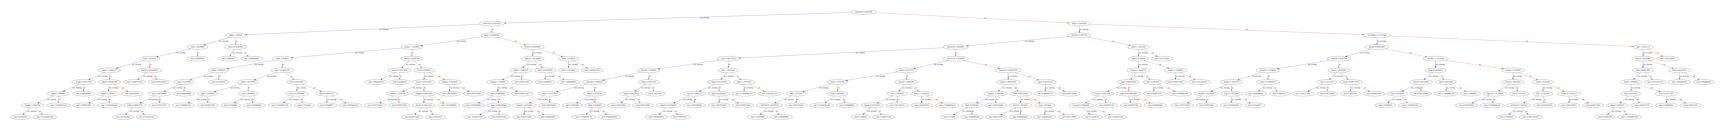

In [52]:
import graphviz
plt.rcParams["figure.figsize"] = [22,40]
xgb.plot_tree(xgb_trained)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

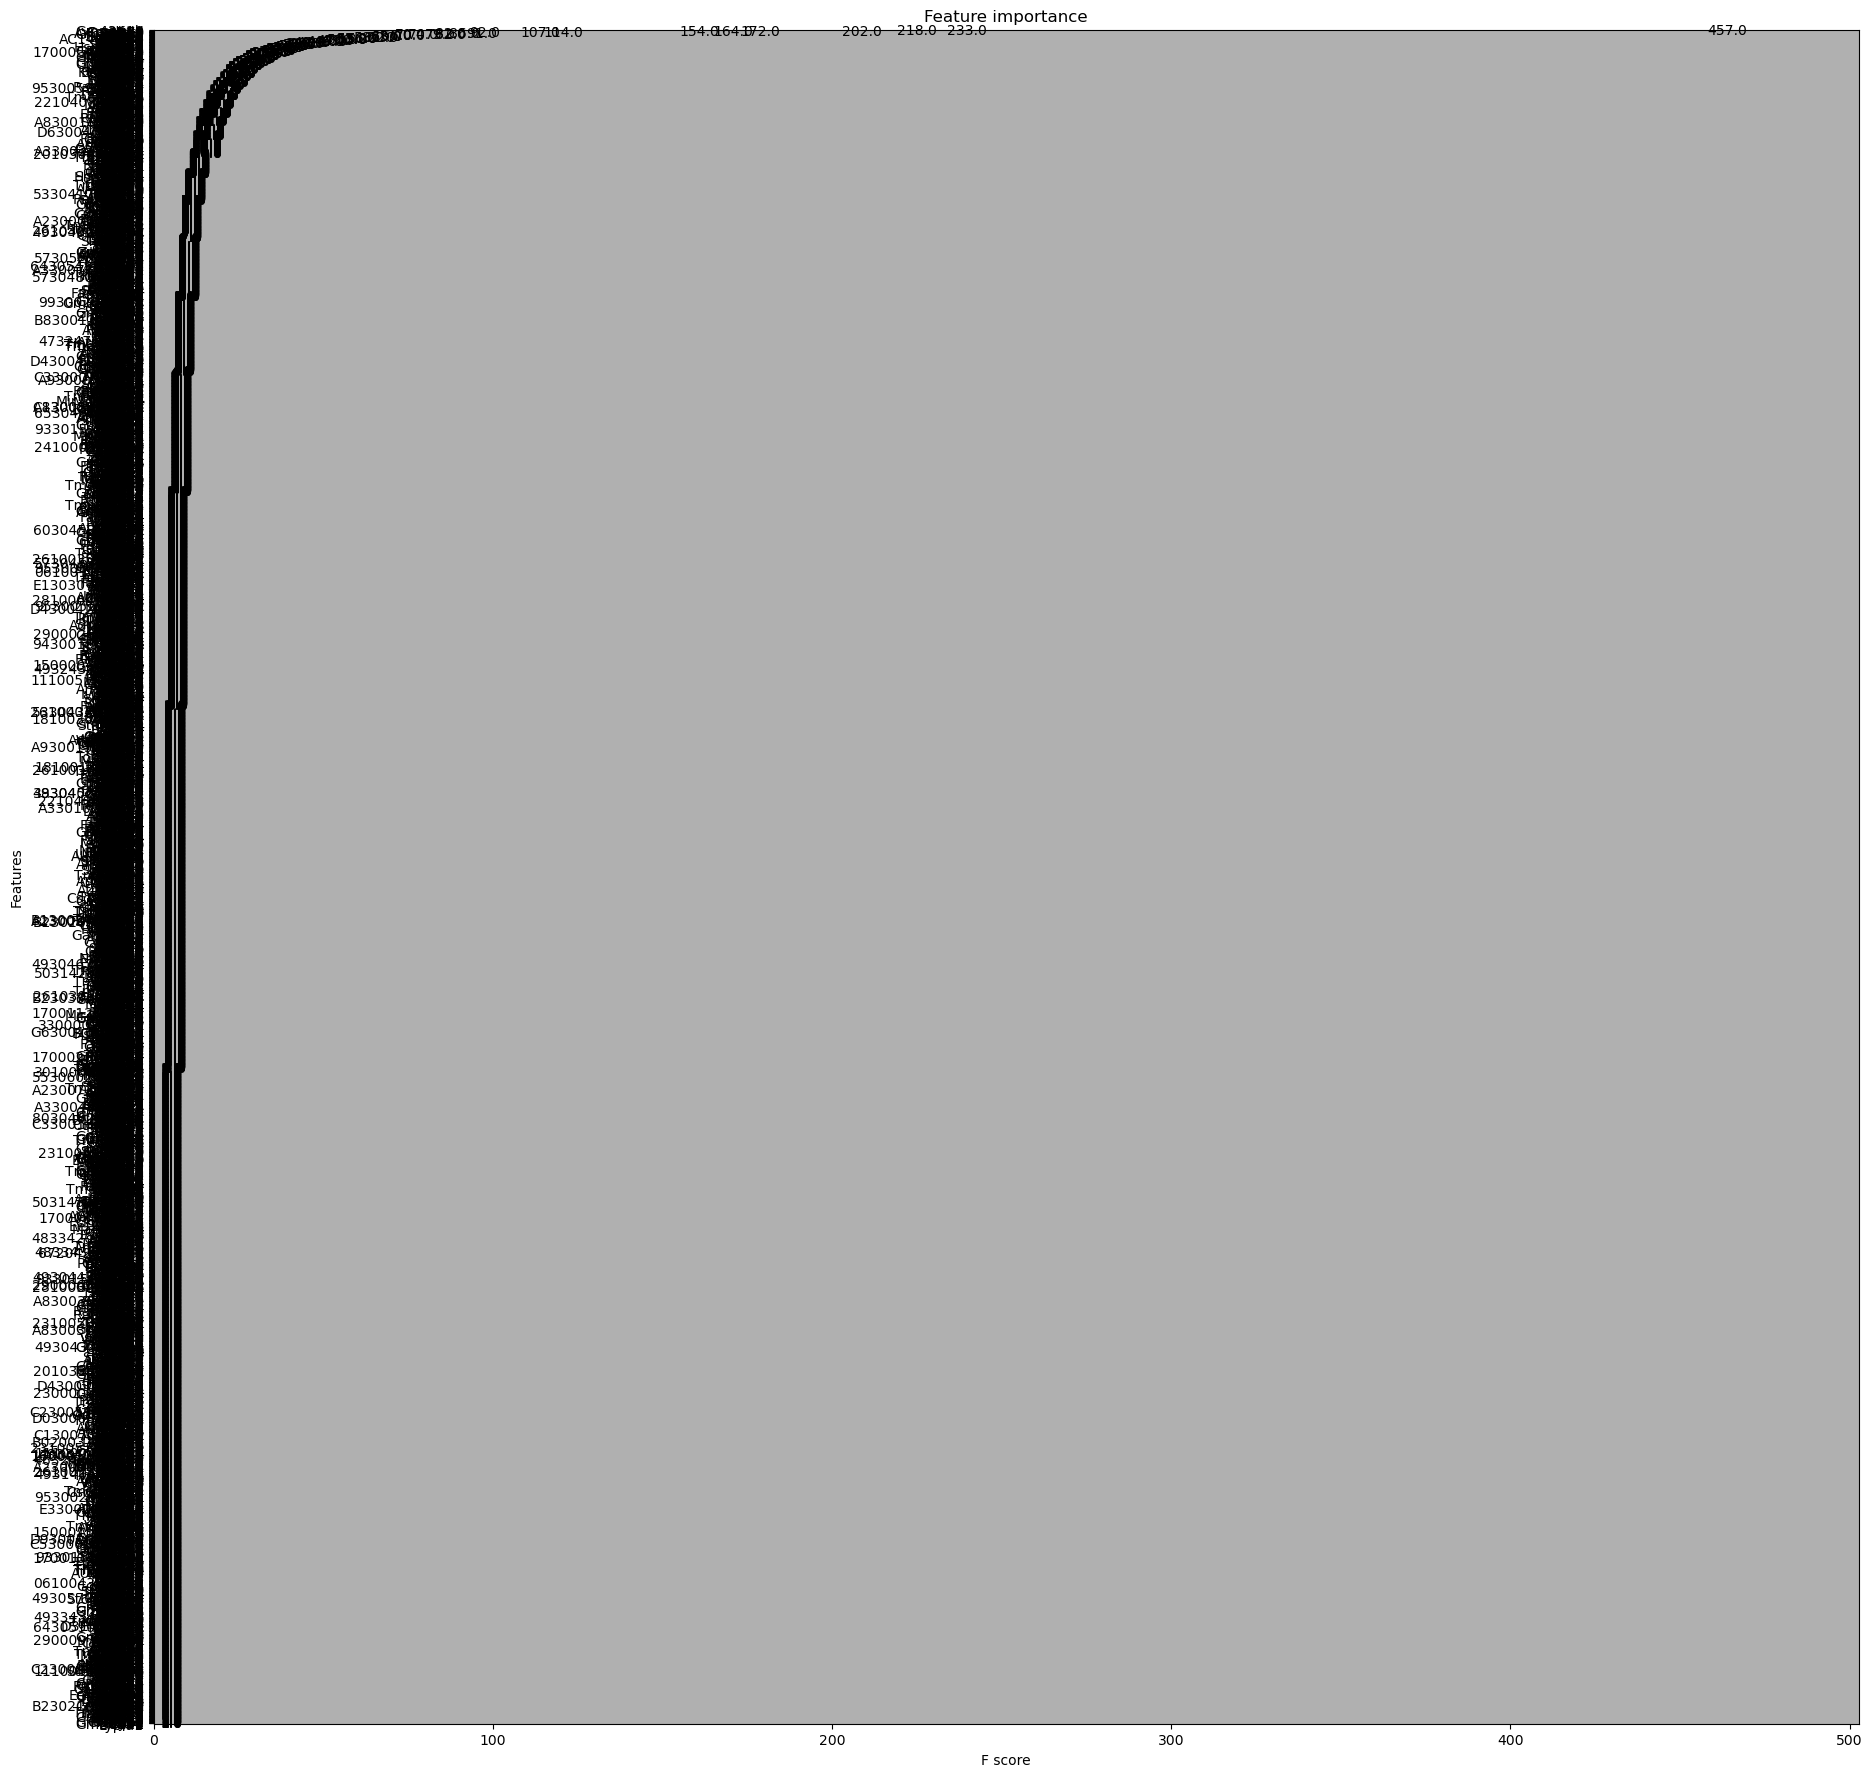

In [53]:
plt.rcParams["figure.figsize"] = [22,22]
xgb.plot_importance(xgb_trained)

as expected alot of features aren't very important but lets still try running our classifier with our raw data 

Raw data. Assess performance

In [54]:
# split into train and validation set using sklearn
y = df['labels']
X = df.loc[:, df.columns != 'labels'] 

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [55]:
# perform a typical split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [56]:
X_train.shape

(4000, 32285)

In [57]:
y_train.shape

(4000,)

Fitting model...
Fitting done!


/Users/simonlee/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-mlogloss:1.01380	test-merror:0.20500	train-mlogloss:1.00720	train-merror:0.14800
[100]	test-mlogloss:0.31092	test-merror:0.13700	train-mlogloss:0.03967	train-merror:0.00000
[200]	test-mlogloss:0.29631	test-merror:0.12800	train-mlogloss:0.00669	train-merror:0.00000
[299]	test-mlogloss:0.29341	test-merror:0.12300	train-mlogloss:0.00263	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.877
XGBoost F1-Score: 0.8769999999999999


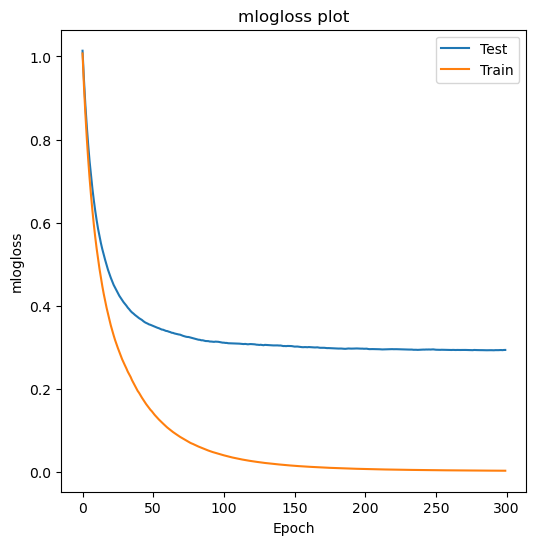

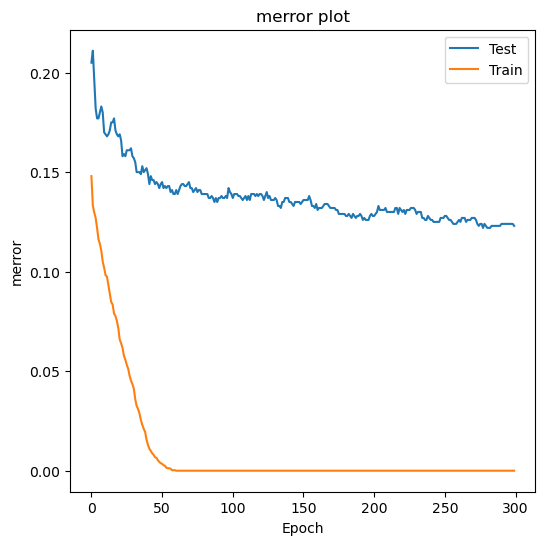

length of features list: 9137
length of feature importance vector 9137


In [58]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=5, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

In [84]:
test = xgb.DMatrix(data['X_test'], label=data['y_test'])
pred = xgb_trained.predict(test)

In [85]:
pred = xgb_trained.predict(test)

In [86]:
print(classification_report(data['y_test'], pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       371
           1       0.84      0.75      0.80       311
           2       0.99      0.96      0.98       318

    accuracy                           0.88      1000
   macro avg       0.88      0.87      0.88      1000
weighted avg       0.88      0.88      0.88      1000



we can run a grid search to find the best hyperparameters available

In [59]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [60]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.1,0.2,0.3],
        'n_estimators': [300,400,500],
        }

In [61]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [107]:
xgb_model_cv = XGBClassifier(objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                             nthread=4,
                             num_class=3,
                             seed=1 # seed is included for reproducibility
)

In [108]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model_cv, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
